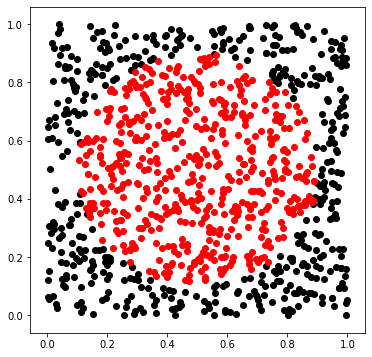

In [1]:
import torch
import math
import matplotlib.pyplot as plt

import Modules
import Optimizer
from helpers import generate_disc_set, plot_data

torch.set_grad_enabled(False)

data, target, data_test, target_test = generate_disc_set(nb_sample=1000, show_data=True)

0 train_loss 525.41 test_error 49.10%


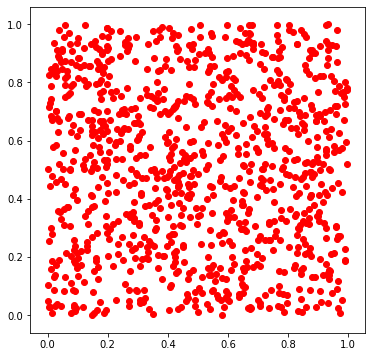

50 train_loss 461.17 test_error 38.10%


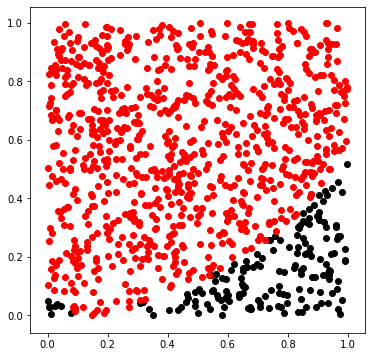

100 train_loss 416.81 test_error 22.40%


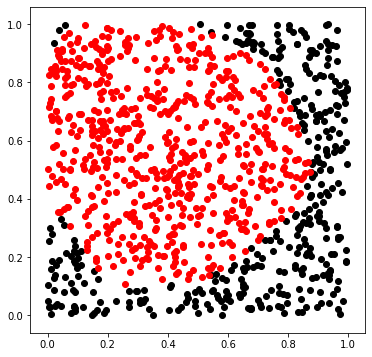

150 train_loss 328.42 test_error 6.90%


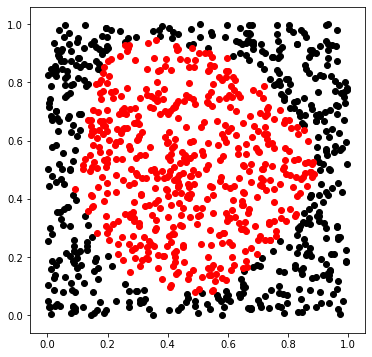

200 train_loss 230.36 test_error 3.30%


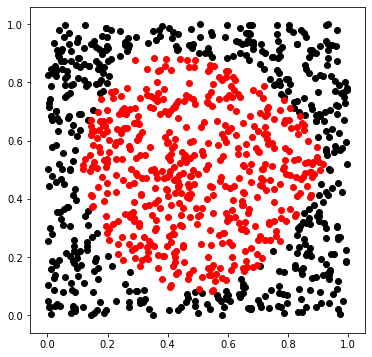

250 train_loss 190.04 test_error 5.50%


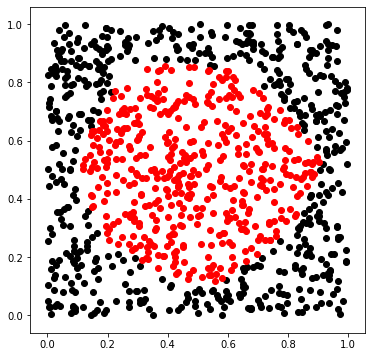

300 train_loss 175.73 test_error 3.20%


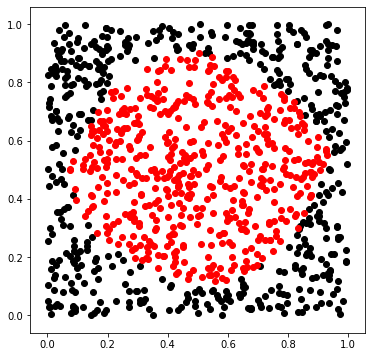

350 train_loss 168.03 test_error 2.70%


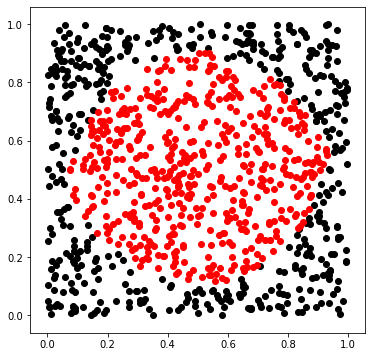

400 train_loss 163.27 test_error 2.90%


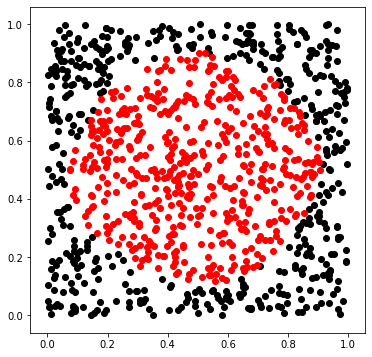

450 train_loss 160.36 test_error 3.30%


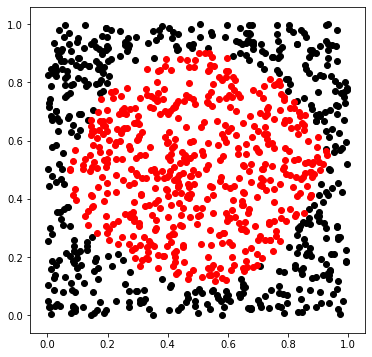

499 train_loss 157.13 test_error 4.00%


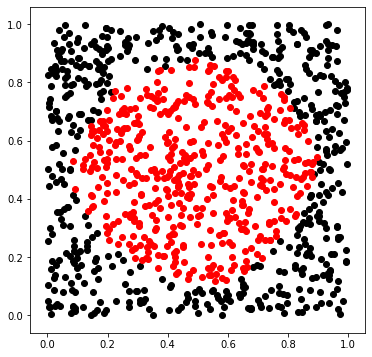

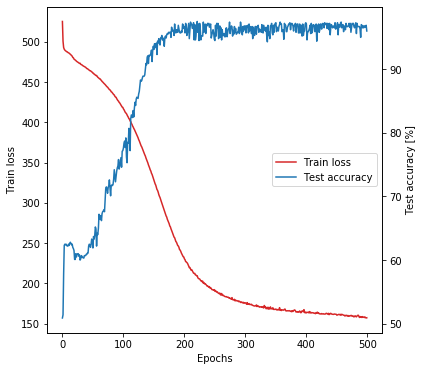

In [2]:
# Train 

nb_epochs = 500
mini_batch_size = 100

# Modules sequence
m1 = Modules.Linear(2,25)
m2 = Modules.Linear(25,25)
m3 = Modules.Linear(25,25)
m4 = Modules.Linear(25,2)

relu1 = Modules.ReLu()
relu2 = Modules.ReLu()
tanh1 = Modules.Tanh()
tanh2 = Modules.Tanh()

sequence = Modules.Sequential(m1, relu1, m2, relu2, m3, tanh1, m4, tanh2)

# loss criterion
MSE = Modules.MSE()

losses = []
test_accs = []

for e in range(nb_epochs):
    
    # train
    sum_loss = 0
    for b in list(torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(range(data.size(0))), batch_size=mini_batch_size, drop_last=False)):
        output = sequence(data[b])
        loss = MSE(output, target[b])
        sequence.zero_grad()
        sequence.backward(MSE.backward(output, target[b]))
        sequence.step()
        sum_loss += loss.item()
    
    losses.append(sum_loss)
    
    # test
    sum_error = 0
    predicted_test_classes = []
    data_plot = []
    for t in list(torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(range(data_test.size(0))), batch_size=mini_batch_size, drop_last=False)):
        test_out = sequence(data_test[t])
        predicted_test_batch_classes = test_out.max(1)[1]
        nb_errors = torch.where(target_test[t] != predicted_test_batch_classes)[0].size(0)
        
        # plot
        sum_error += nb_errors
        predicted_test_classes.append(predicted_test_batch_classes)
        data_plot.append(data_test[t])
    
    test_accs.append(100 - ((100 * sum_error) / data_test.size(0)))
    
    # plot
    predicted_test_classes = torch.cat(predicted_test_classes, dim=0)
    data_plot = torch.cat(data_plot, dim=0)
    
    if e%int((nb_epochs/10)) == 0 or e == nb_epochs-1:
        print('{:d} train_loss {:.02f} test_error {:.02f}%'.format(e, sum_loss, (100 * sum_error) / data_test.size(0)))
        plot_data(data_plot, predicted_test_classes)

        
# Train loss and test acc plot 
fig, ax1 = plt.subplots(figsize=(6,6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train loss')
plt1 = ax1.plot(range(len(losses)), losses, color='tab:red', label='Train loss')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  
ax2.set_ylabel('Test accuracy [%]')  
plt2 = ax2.plot(range(len(test_accs)), test_accs, color='tab:blue', label='Test accuracy')
ax2.tick_params(axis='y')

plts = plt1+plt2
labs = [p.get_label() for p in plts]
plt.legend(plts, labs, loc='center right')
plt.show()